<a href="https://colab.research.google.com/github/chupvl/gcolab/blob/main/2023_03_13_Testing_Jazzy_for_solubility_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2023-03-13: Solubility prediction using Jazzy features (hydration free energies)

**Goal**: testing if free energy of hydration (without free parameters) from Jazzy have an impact on prediction of compound solubility.

Data is taken from [SolCuration](https://github.com/Mengjintao/SolCuration/), that's a derivate from Meng et al [paper](https://www.nature.com/articles/s41597-022-01154-3) + additional datasets. Median is taken for measurments and compounds with SD > 0.5 are removed.

**TLDR**: Jazzy descriptors does not have positive impact on solubility prediction.

**Links**:
* [Paper](https://www.nature.com/articles/s41598-023-30089-x)
* [Jazzy RTD](https://jazzy.readthedocs.io/en/latest/cookbook.html)
* [Jazzy Github](https://github.com/AstraZeneca/jazzy)

## Libs: installation

In [1]:
!pip install jazzy -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.5/97.5 KB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.7/104.7 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.6/258.6 KB 8.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.2/147.2 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━

In [2]:
!pip install rdkit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 32.9 MB/s eta 0:00:00


In [3]:
!pip install kallisto

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install catboost
# it's faster compared to xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 18.7 MB/s eta 0:00:00


## Libs

In [5]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True
from rdkit.Chem.Draw import MolsToGridImage

import numpy as np
import xgboost as xgb
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

In [6]:
# testing Jazzy
from jazzy.api import molecular_vector_from_smiles
from jazzy.api import deltag_from_smiles

molecular_vector_from_smiles("CC(=O)NC1=CC=C(C=C1)O")
# working just fine
# dgtot - Gibbs free energy of hydration (kJ/mol)

{'sdc': 4.2936,
 'sdx': 1.4202,
 'sa': 2.461,
 'dga': -3.0141,
 'dgp': -51.5689,
 'dgtot': -54.583}

*   dgtot - Gibbs free energy of hydration (kJ/mol)
*   sdc - sum of C–H donor strengths
*   sdx - sum of X–H donor strengths where X is any non-carbon atom
*   sa - sum of all atomic acceptor strengths
*   dga
*   dgp
*   dgtot

In [7]:
def smiles_std(smiles):
  try:
    smiles = rdMolStandardize.StandardizeSmiles(smiles)
    lfc = rdMolStandardize.LargestFragmentChooser()
    mol_std = lfc.choose(Chem.MolFromSmiles(smiles))
    smiles_std = Chem.MolToSmiles(mol_std)
    return smiles_std
  except:
    return None

In [8]:
def rdkit_calc_2d_descriptors(smiles):
    """
    Calculates all possible chemical descriptors for a given molecule and returns them as a dictionary.
    
    Args:
        molecule (str): A string representation of a molecule in SMILES format.
        
    Returns:
        dict: A dictionary of all possible chemical descriptors for the molecule, with None values for descriptors that could not be calculated.
    """
    descriptors = { descriptor:None for descriptor, function in Descriptors.descList }
    try:
      mol = Chem.MolFromSmiles(smiles)
      descriptors = { descriptor:function(mol) for descriptor, function in Descriptors.descList }
      return descriptors
    except:
      return descriptors

In [9]:
def get_fp(smiles):
  fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles), useChirality=False, radius=3, nBits = 1024)
  return np.array(fp)

## Data: prep

In [10]:
datasets = {}
datasets['aqsol'] = pd.read_csv('https://raw.githubusercontent.com/Mengjintao/SolCuration/master/cure/aqsol_cure.csv')
datasets['chembl'] = pd.read_csv('https://raw.githubusercontent.com/Mengjintao/SolCuration/master/cure/chembl_cure.csv')
datasets['esol'] = pd.read_csv('https://raw.githubusercontent.com/Mengjintao/SolCuration/master/cure/esol_cure.csv')
datasets['oechem'] = pd.read_csv('https://raw.githubusercontent.com/Mengjintao/SolCuration/master/cure/ochem_cure.csv')
datasets['phys'] = pd.read_csv('https://raw.githubusercontent.com/Mengjintao/SolCuration/master/cure/phys_cure.csv')

In [ ]:
%%capture
for k,v in datasets.items():
  v['smiles_std'] = [smiles_std(s) for s in v['smiles']]
  v['dataset'] = k
  datasets[k] = v

In [ ]:
df = pd.concat(datasets.values())
df.head()

,smiles,logS,weight,smiles_std,dataset
0,B12B3B4B1C234,-4.74240,0.250,B12B3B4B1C234,aqsol
1,Br/C=C/Br,-1.47611,0.675,Br/C=C/Br,aqsol
2,Br/C=C\Br,-1.36389,0.675,Br/C=C\Br,aqsol
3,BrC(Br)(Br)Br,-3.14005,1.000,BrC(Br)(Br)Br,aqsol
4,BrC(Br)Br,-1.88302,1.000,BrC(Br)Br,aqsol


In [ ]:
df['dataset'].value_counts()

chembl    28675
aqsol      9061
oechem     3766
phys       2001
esol       1157
Name: dataset, dtype: int64

In [ ]:
df_mod = df.groupby('smiles_std')['logS'].agg(['median', 'std']).reset_index()
print(df_mod.shape)
df_mod.head()

(35138, 3)


,smiles_std,median,std
0,B12B3B4B1C234,-4.742400,NaN
1,Br/C=C/Br,-1.398055,0.110386
2,Br/C=C\Br,-1.376945,0.018463
3,BrC(Br)(Br)Br,-3.140000,0.000025
4,BrC(Br)Br,-1.876355,0.035501


In [ ]:
# filling NaN
df_mod['std'] = df_mod['std'].fillna(0)
#
nSTDg1 = df_mod[df_mod['std'] > 1].shape[0]
nSTDg05 = df_mod[df_mod['std'] > 0.5].shape[0]
print(f'Number of compounds with logS SD > 1: {nSTDg1}')
print(f'Number of compounds with logS SD > 0.5: {nSTDg05}')

Number of compounds with logS SD > 1: 888
Number of compounds with logS SD > 0.5: 1823


In [ ]:
# dropping compounds with SD > 0.5
df_mod = df_mod[df_mod['std'] < 0.5].reset_index(drop=True)
df_mod.shape

(33315, 3)

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df_mod.to_csv('/content/gdrive/MyDrive/gcollab/data/jazzy-test/solubility-SolCuration-combined.csv', index=False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Descriptors: Jazzy

In [ ]:
props = ['sdc', 'sdx', 'sa', 'dga', 'dgp', 'dgtot']
def_empty = dict.fromkeys(props, None)

In [ ]:
def molecular_vector_from_smiles_debug(smiles):
  try:
    return molecular_vector_from_smiles(smiles)
  except:
    return def_empty

In [ ]:
%%time
# getting Jazzy features
X = [ molecular_vector_from_smiles_debug(s) for s in df_mod['smiles_std'].values ]
df_X = pd.DataFrame(X)

ERROR:root:The RDKit embedding has failed for the molecule: C/N=C(\S)NCCCCC(NC(=O)C(Cc1cccc2ccccc12)Cc1cccc2ccccc12)C(=O)NC(CC(C)C)[C@@H](O)CC(=O)NC(CC(C)C)C(=O)NCc1ccccc1
ERROR:root:The RDKit embedding has failed for the molecule: C/N=C(\S)NCCCCC(NC(=O)C(Cc1ccccc1)NS(=O)(=O)N1CCOCC1)C(=O)NC(CC1CCCCC1)[C@@H](O)CC(=O)N1CCOC(CCN)C1
ERROR:root:The RDKit embedding has failed for the molecule: C=C(C)[C@@H]1CC[C@]2(C(=O)OCc3cn(CC(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@H](CCCNC(=N)N)C(=O)O)nn3)CC[C@]3(C)[C@H](CC[C@@H]4[C@@]5(C)CC[C@H](O)C(C)(C)[C@@H]5CC[C@]43C)[C@@H]12
ERROR:root:The RDKit embedding has failed for the molecule: C=C(C)[C@@H]1CC[C@]2(C(=O)OCc3cn(CC(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCNC(=N)N)C(=O)O)nn3)CC[C@]3(C)[C@H](CC[C@@H]4[C@@]5(C)CC[C@H](O)C(C)(C)[C@@H]5CC[C@]43C)[C

CPU times: user 3h 34min 47s, sys: 2h 37min 27s, total: 6h 12min 15s
Wall time: 3h 16min 11s


In [ ]:
# merging with original DF
df_mod_wJ = pd.concat([df_mod, df_X], axis=1)
df_mod_wJ.to_csv('/content/gdrive/MyDrive/gcollab/data/jazzy-test/solubility-SolCuration-combined-wJazzyDescr.csv', index=False)

In [12]:
df_mod_wJ = pd.read_csv('/content/gdrive/MyDrive/gcollab/data/jazzy-test/solubility-SolCuration-combined-wJazzyDescr.csv')

/usr/local/lib/python3.9/dist-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


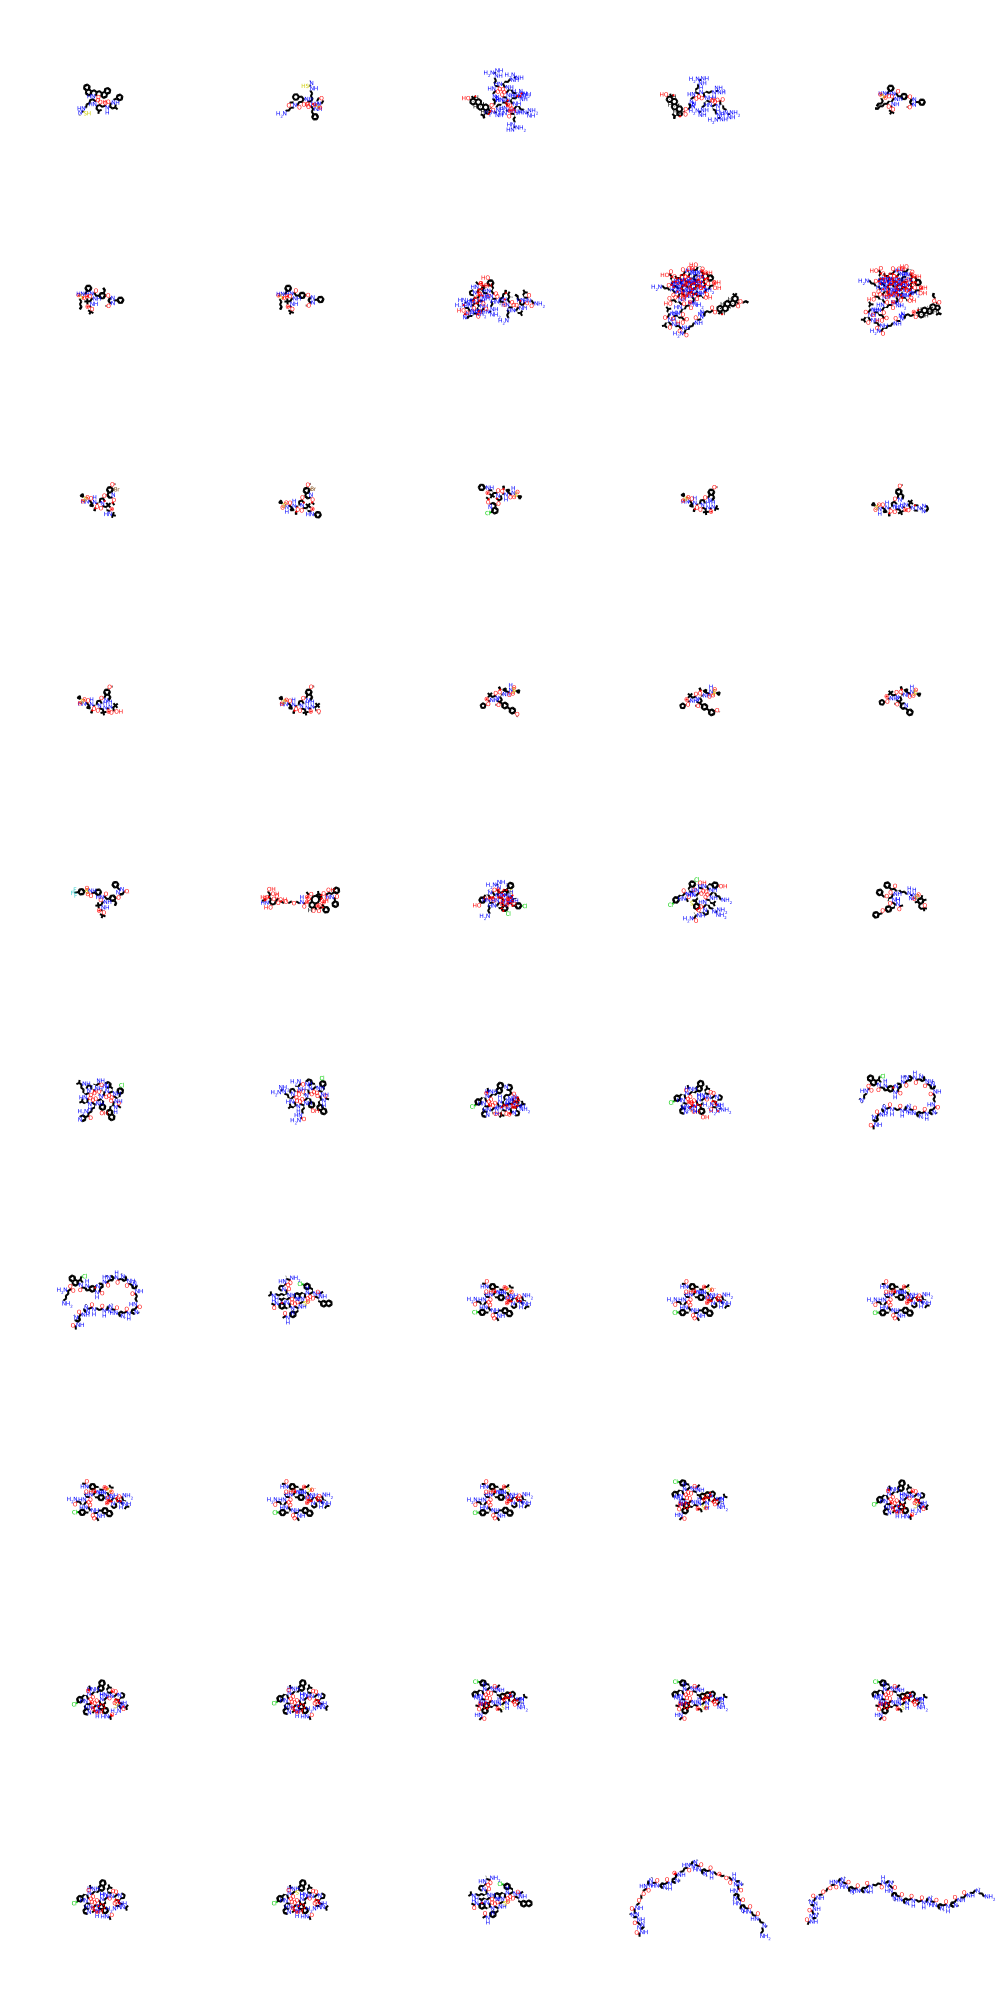

In [13]:
# Let's check some issues
buggy_smiles = df_mod_wJ[df_mod_wJ['dgtot'].isnull()]['smiles_std'].values
buggy_mols = [Chem.MolFromSmiles(smiles) for smiles in buggy_smiles]
MolsToGridImage(buggy_mols, molsPerRow=5)
# all buggy compounds are big, or greasy or both

In [15]:
# let's remove them
df_mod_wJ = df_mod_wJ.dropna().reset_index(drop=True)

In [19]:
# adding 2D descriptors
X_2d_descr = [ rdkit_calc_2d_descriptors(s) for s in df_mod_wJ['smiles_std'].values ]
df_X_2d_descr = pd.DataFrame(X_2d_descr)
df_X_2d_descr_names = df_X_2d_descr.columns

In [33]:
df_X_2d_descr.values.shape

(33089, 208)

In [24]:
# Morgan fingerprint
lst_X_mrg = [ get_fp(s) for s in df_mod_wJ['smiles_std'].values ]
X_mrg = np.vstack(lst_X_mrg)

In [27]:
y = df_mod_wJ['median'].values

In [30]:
jazzy_props = ['std', 'sdc', 'sdx', 'sa', 'dga', 'dgp', 'dgtot']

In [37]:
d_ts = {}
d_ts['Jazzy'] = df_mod_wJ[jazzy_props].values
d_ts['2D'] = df_X_2d_descr.values
d_ts['Morgan'] = X_mrg
# combos
d_ts['combo_Morgan_Jazzy'] = np.concatenate((df_mod_wJ[jazzy_props].values, X_mrg), axis=1)
d_ts['combo_Morgan_2D'] = np.concatenate((df_X_2d_descr.values, X_mrg), axis=1)
d_ts['combo_2D_Jazzy'] = np.concatenate((df_X_2d_descr.values, df_mod_wJ[jazzy_props].values), axis=1)
d_ts['combo_2D_Jazzy_Morgan'] = np.concatenate((df_X_2d_descr.values, df_mod_wJ[jazzy_props].values, X_mrg), axis=1)

<Axes: >

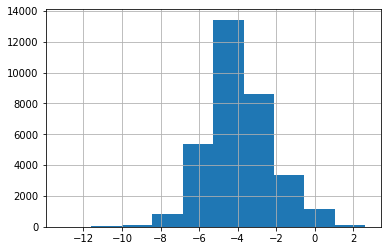

In [59]:
df_mod_wJ['median'].hist()

## Modeling

In [48]:
# 5-fold CV, let's go easy...
kf = KFold(n_splits=5, shuffle=True)

In [38]:
from catboost import CatBoostRegressor

In [49]:
benchmark = []
for i, (train_index, test_index) in enumerate(kf.split(X_mrg)):
  for k,v in d_ts.items():
    X_train = v[train_index]
    X_test = v[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    model = CatBoostRegressor()
    model.fit(X_train, y_train, verbose=False)
    preds = model.predict(X_test)
    d = {}
    d['fold'] = i
    d['descriptors'] = k
    d['R2'] = r2_score(y_test, preds)
    d['mean_absolute_percentage_error'] = mean_absolute_percentage_error(y_test, preds)
    d['mse'] = mean_squared_error(y_test, preds)
    d['rmse'] = mean_squared_error(y_test, preds, squared=False)
    print(f"Fold {i} for {k}: R2 - {round(d['R2'], 2)}, RMSE - {round(d['rmse'], 2)}")
    benchmark.append(d)

Fold 0 for Jazzy: R2 - 0.48, RMSE - 1.21
Fold 0 for 2D: R2 - 0.76, RMSE - 0.83
Fold 0 for Morgan: R2 - 0.64, RMSE - 1.01
Fold 0 for combo_Morgan_Jazzy: R2 - 0.7, RMSE - 0.92
Fold 0 for combo_Morgan_2D: R2 - 0.77, RMSE - 0.8
Fold 0 for combo_2D_Jazzy: R2 - 0.76, RMSE - 0.83
Fold 0 for combo_2D_Jazzy_Morgan: R2 - 0.77, RMSE - 0.81
Fold 1 for Jazzy: R2 - 0.49, RMSE - 1.21
Fold 1 for 2D: R2 - 0.76, RMSE - 0.83
Fold 1 for Morgan: R2 - 0.65, RMSE - 1.0
Fold 1 for combo_Morgan_Jazzy: R2 - 0.71, RMSE - 0.91
Fold 1 for combo_Morgan_2D: R2 - 0.76, RMSE - 0.82
Fold 1 for combo_2D_Jazzy: R2 - 0.76, RMSE - 0.83
Fold 1 for combo_2D_Jazzy_Morgan: R2 - 0.76, RMSE - 0.82
Fold 2 for Jazzy: R2 - 0.47, RMSE - 1.21
Fold 2 for 2D: R2 - 0.74, RMSE - 0.84
Fold 2 for Morgan: R2 - 0.63, RMSE - 1.01
Fold 2 for combo_Morgan_Jazzy: R2 - 0.68, RMSE - 0.93
Fold 2 for combo_Morgan_2D: R2 - 0.75, RMSE - 0.83
Fold 2 for combo_2D_Jazzy: R2 - 0.74, RMSE - 0.85
Fold 2 for combo_2D_Jazzy_Morgan: R2 - 0.75, RMSE - 0.83
Fold

In [51]:
df_benchmark = pd.DataFrame(benchmark)
df_benchmark.to_csv('/content/gdrive/MyDrive/gcollab/data/jazzy-test/solubility-SolCuration-combined-catboost-bmk.csv', index=False)

In [57]:
df_benchmark_med = df_benchmark.groupby(['descriptors']).median()
df_benchmark_med = df_benchmark_med.sort_values('R2').drop(columns=['fold'])
df_benchmark_med

,R2,mean_absolute_percentage_error,mse,rmse
descriptors,,,,
Jazzy,0.483166,0.697701,1.464090,1.209996
Morgan,0.647810,0.636827,1.010520,1.005246
combo_Morgan_Jazzy,0.709274,0.522402,0.833167,0.912780
combo_2D_Jazzy,0.755690,0.422069,0.692619,0.832237
2D,0.756753,0.416461,0.689372,0.830284
combo_2D_Jazzy_Morgan,0.770472,0.431028,0.650256,0.806384
combo_Morgan_2D,0.772232,0.412204,0.645269,0.803286
